In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/movie-data/plot_summaries.txt
/kaggle/input/movie-data/movie_metadata.csv


In [3]:
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [4]:
movie = pd.read_csv("/kaggle/input/movie-data/movie_metadata.csv", header=None)

In [5]:
movie.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [6]:
movie.columns = ["movie_id", 1, "movie_name", 3, 4, 5 ,6, 7, "genre"]

In [7]:
movie.head(1)

,movie_id,1,movie_name,3,4,5,6,7,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"


In [8]:
plot = pd.read_csv("/kaggle/input/movie-data/plot_summaries.txt", sep = '\t', header=None)

In [9]:
plot.columns = ["movie_id", "plot"]

In [10]:
plot.head()

,movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e..."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo..."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r..."


In [11]:
data = movie[["movie_id", "movie_name", "genre"]].merge(plot, on="movie_id")
data_test = pd.merge(plot, movie[["movie_id", "movie_name", "genre"]], on= "movie_id")

In [12]:
print(data.shape, data_test.shape)

(42204, 4) (42204, 4)


In [13]:
data.head()

,movie_id,movie_name,genre,plot
0,975900,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}","Set in the second half of the 22nd century, the film depicts Mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. The Martian society has become largely matriarchal, with women in most positions of authority. The story concerns a ..."
1,9363483,White Of The Eye,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}","A series of murders of rich young women throughout Arizona bear distinctive signatures of a serial killer. Clues lead Detective Charles Mendoza to visit Paul White, a sound expert installing hi-fi systems in wealthy people's homes. His special talent is to make a noise which echoes through the a..."
2,261236,A Woman in Flames,"{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustrated and leaves her arrogant husband. She is drawn to the idea of becoming a call girl. With the aid of a prostitute named Yvonne, Eva learns the basics and then they both set out looking for Johns together. She meets a charming man who she falls in l..."
3,18998739,The Sorcerer's Apprentice,"{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fantasy"", ""/m/03k9fj"": ""Adventure"", ""/m/03q4nz"": ""World cinema""}","Every hundred years, the evil Morgana returns to claim Fingall's talisman from the wizard Merlin, with which she intends to destroy the world. For the last fourteen hundred years she has failed... now she intends to conquer all. Young Ben Clark moves with his parents to a new town, where he be..."
4,6631279,Little city,"{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ""Ensemble Film"", ""/m/01t_vv"": ""Comedy-drama"", ""/m/07s9rl0"": ""Drama"", ""/m/01z4y"": ""Comedy"", ""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""Romance Film""}","Adam, a San Francisco-based artist who works as a cab driver on the side, is having a hard time committing to his girlfriend, Nina. She wants to take their relationship to the next level, but he hasn't really gotten over his ex-girlfriend, Kate, who left him for another woman and is reluctant to..."


In [14]:
data[data["movie_name"] == "Narasimham"]

,movie_id,movie_name,genre,plot
852,20663735,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}","Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e..."


In [15]:
data["genre"][0]

'{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}'

In [16]:
list(json.loads(data["genre"][0]).values())

['Thriller',
 'Science Fiction',
 'Horror',
 'Adventure',
 'Supernatural',
 'Action',
 'Space western']

In [17]:
genre = []

for i in data["genre"]:
    #print(list(json.loads(i).values()))
    genre.append(list(json.loads(i).values()))

In [18]:
data["genre_new"] = genre

In [19]:
data.head(1)

,movie_id,movie_name,genre,plot,genre_new
0,975900,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}","Set in the second half of the 22nd century, the film depicts Mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. The Martian society has become largely matriarchal, with women in most positions of authority. The story concerns a ...","[Thriller, Science Fiction, Horror, Adventure, Supernatural, Action, Space western]"


In [20]:
data.dtypes

movie_id       int64
movie_name    object
genre         object
plot          object
genre_new     object
dtype: object

In [21]:
#type(str(data["genre_new"]))
data_new = data[~(data["genre_new"].str.len() == 0)]

In [22]:
data_new.shape

(41793, 5)

In [23]:
dumm = []

for i in genre:
    for j in i:
        #print(j)
        dumm.append(j)

In [24]:
all_genre = list(set(dumm))

In [25]:
var = sum(genre,[])

In [26]:
len(all_genre)

363

In [27]:
genre_new = nltk.FreqDist(dumm)

In [28]:
genre_new

FreqDist({'Drama': 19134, 'Comedy': 10467, 'Romance Film': 6666, 'Thriller': 6530, 'Action': 5868, 'World cinema': 5153, 'Crime Fiction': 4275, 'Horror': 4082, 'Black-and-white': 3731, 'Indie': 3668, ...})

In [29]:
type(genre_new)

nltk.probability.FreqDist

In [30]:
len(genre_new.keys())

363

In [31]:
genre_df = pd.DataFrame.from_dict(genre_new, orient="index")

In [32]:
genre_df.columns = ["Count"]
genre_df.index.name = ["Genre"]

In [33]:
genre_df.head()

,Count
[Genre],
Thriller,6530
Science Fiction,2339
Horror,4082
Adventure,3248
Supernatural,571


In [34]:
#genre_df["Genre"] = genre_df.index
#genre_df.reset_index()
del genre_df.index.name

In [35]:
genre_df = genre_df.reset_index()

In [36]:
genre_df.shape

(363, 2)

In [37]:
genre_df.columns = ["Genre", "Count"]

In [38]:
genre_df.head(2)

,Genre,Count
0,Thriller,6530
1,Science Fiction,2339


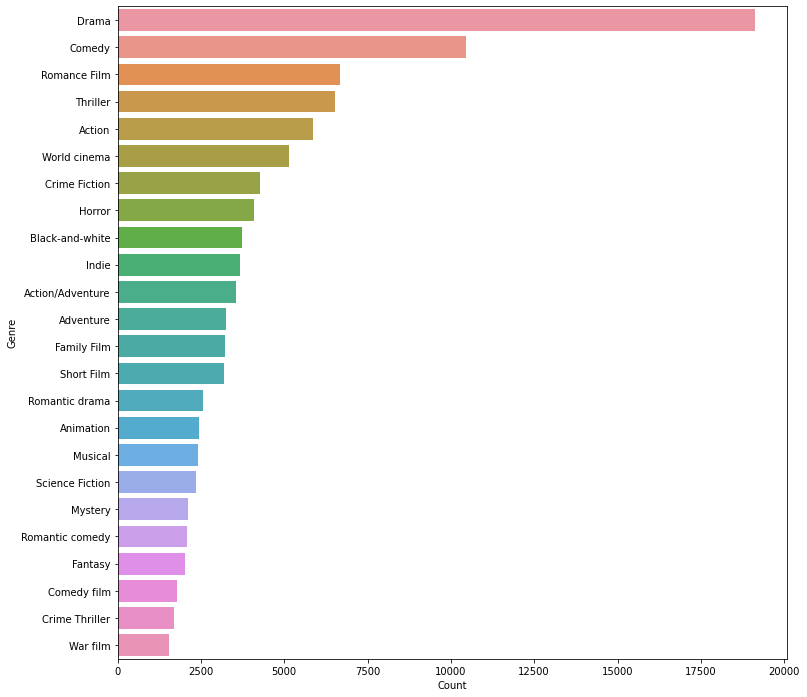

In [39]:
plt.figure(figsize=(12,12))
sns.barplot(data=genre_df.sort_values("Count", ascending=False).loc[:20, :], x="Count", y="Genre")


In [40]:
def clean_text(text):
    
    text = re.sub("\'", "", text)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = " ".join(text.split())
    text = text.lower()
    
    return text

In [41]:
data_new["clean_plot"] = data_new["plot"].apply(lambda x : clean_text(x))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
data_new.head(2)

,movie_id,movie_name,genre,plot,genre_new,clean_plot
0,975900,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}","Set in the second half of the 22nd century, the film depicts Mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. The Martian society has become largely matriarchal, with women in most positions of authority. The story concerns a ...","[Thriller, Science Fiction, Horror, Adventure, Supernatural, Action, Space western]",set in the second half of the nd century the film depicts mars as a planet that has been terraformed allowing humans to walk on the surface without wearing pressure suits the martian society has become largely matriarchal with women in most positions of authority the story concerns a police offi...
1,9363483,White Of The Eye,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}","A series of murders of rich young women throughout Arizona bear distinctive signatures of a serial killer. Clues lead Detective Charles Mendoza to visit Paul White, a sound expert installing hi-fi systems in wealthy people's homes. His special talent is to make a noise which echoes through the a...","[Thriller, Erotic thriller, Psychological thriller]",a series of murders of rich young women throughout arizona bear distinctive signatures of a serial killer clues lead detective charles mendoza to visit paul white a sound expert installing hi fi systems in wealthy peoples homes his special talent is to make a noise which echoes through the air c...


In [43]:
def freq_plot(text):
    
    words = " ".join([x for x in text])
    words = words.split()
    fdist = nltk.FreqDist(words)
    return fdist


In [44]:
fdist = freq_plot(data_new["clean_plot"])

In [45]:
words_df = pd.DataFrame.from_dict(fdist, orient="index")

In [46]:
words_df = words_df.reset_index()

In [47]:
words_df.columns = ["Word","Count"]

In [48]:
words_df.head()

,Word,Count
0,set,6109
1,in,220618
2,the,818332
3,second,3410
4,half,1992


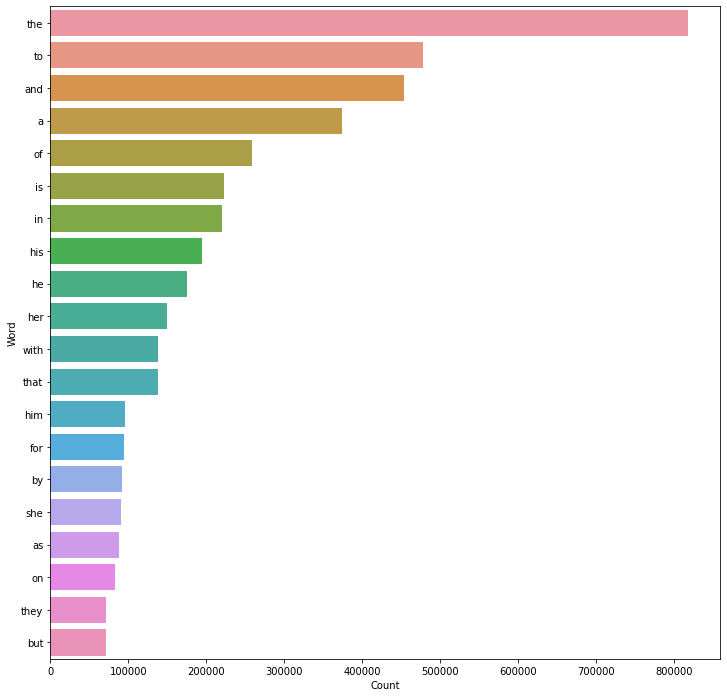

In [49]:
plt.figure(figsize=(12,12))
sns.barplot(data= words_df.sort_values(by="Count",ascending= False).iloc[:20, :], x = "Count", y= "Word")

In [50]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [51]:
from nltk.corpus import stopwords

In [52]:
stopwords = set(stopwords.words("english"))

In [53]:
def remove_stopwords(text):
    no_stop = []
    
    for i in text.split():
        if i not in stopwords:
            no_stop.append(i)
    return " ".join(no_stop)

In [54]:
data_new["clean_plot"] = data_new["clean_plot"].apply(lambda x : remove_stopwords(x))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
data_new.head(2)

,movie_id,movie_name,genre,plot,genre_new,clean_plot
0,975900,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}","Set in the second half of the 22nd century, the film depicts Mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. The Martian society has become largely matriarchal, with women in most positions of authority. The story concerns a ...","[Thriller, Science Fiction, Horror, Adventure, Supernatural, Action, Space western]",set second half nd century film depicts mars planet terraformed allowing humans walk surface without wearing pressure suits martian society become largely matriarchal women positions authority story concerns police officer melanie ballard second command small team alongside sergeant jericho sent...
1,9363483,White Of The Eye,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}","A series of murders of rich young women throughout Arizona bear distinctive signatures of a serial killer. Clues lead Detective Charles Mendoza to visit Paul White, a sound expert installing hi-fi systems in wealthy people's homes. His special talent is to make a noise which echoes through the a...","[Thriller, Erotic thriller, Psychological thriller]",series murders rich young women throughout arizona bear distinctive signatures serial killer clues lead detective charles mendoza visit paul white sound expert installing hi fi systems wealthy peoples homes special talent make noise echoes air cavities head shows sound speakers come echo room ma...


In [56]:
from sklearn.preprocessing import MultiLabelBinarizer

In [57]:
multilabel_bina = MultiLabelBinarizer()
multilabel_bina.fit(data_new["genre_new"])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [58]:
y = multilabel_bina.transform(data_new["genre_new"])

In [59]:
tfidf_vect = TfidfVectorizer(max_df= 0.8, max_features=10000)

In [60]:
data_new.shape

(41793, 6)

In [61]:
y.shape

(41793, 363)

In [62]:
xtrain, xval, ytrain, yval = train_test_split(data_new["clean_plot"], y, test_size = 0.2, random_state= 9)

In [63]:
tfidf_vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=10000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [64]:
xval.shape

(8359,)

In [65]:
xtrain_tfidf = tfidf_vect.fit_transform(xtrain)
xval_tfidf = tfidf_vect.transform(xval)

In [66]:
xtrain_tfidf.shape

(33434, 10000)

In [67]:
xval_tfidf.shape

(8359, 10000)

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [70]:
logistic_mod = LogisticRegression()
onevsall = OneVsRestClassifier(logistic_mod)

In [71]:
onevsall.fit(xtrain_tfidf, ytrain)

/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 202 is present in all training examples.
  str(classes[c]))
/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 241 is present in all training examples.
  str(classes[c]))
/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 245 is present in all training examples.
  str(classes[c]))
/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 361 is present in all training examples.
  str(classes[c]))


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [72]:
y_pred = onevsall.predict(xval_tfidf)

In [74]:
y_pred[2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [78]:
multilabel_bina.inverse_transform(y_pred)[34]

('Black-and-white', 'Comedy')

In [80]:
print(classification_report(yval, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00         2
           2       0.66      0.25      0.36      1237
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00        78
           5       0.51      0.09      0.16       704
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00        28
           8       0.71      0.12      0.21       681
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        14
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00        19
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00        24
          16       0.00      0.00      0.00         2
          17       0.00    

In [81]:
y_pred_prob = onevsall.predict_proba(xval_tfidf)

In [82]:
t = 0.3
y_pred_new = (y_pred_prob >= t).astype(int)

In [84]:
print(classification_report(yval, y_pred_new))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00         2
           2       0.56      0.51      0.53      1237
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00        78
           5       0.47      0.32      0.38       704
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00        28
           8       0.55      0.31      0.40       681
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        14
          11       0.00      0.00      0.00         5
          12       1.00      0.05      0.10        19
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00        24
          16       0.00      0.00      0.00         2
          17       0.00    

In [85]:
def new_val(x):
    
    x = clean_text(x)
    x = remove_stopwords(x)
    x_vec = tfidf_vect.transform([x])
    x_pred = onevsall.predict(x_vec)
    
    return multilabel_bina.inverse_transform(x_pred)

In [88]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Movie: ", data_new['movie_name'][k], "\nPredicted genre: ", new_val(xval[k])), print("Actual genre: ",data_new['genre_new'][k], "\n")

Movie:  The Killers 
Predicted genre:  [('Black-and-white',)]
Actual genre:  ['Thriller', 'Crime Fiction', 'Drama', 'Black-and-white', 'Film noir'] 

Movie:  Maya Machindra 
Predicted genre:  [('Drama',)]
Actual genre:  ['Drama'] 

Movie:  Keshu 
Predicted genre:  [('Drama',)]
Actual genre:  ["Children's", 'Drama'] 

Movie:  The New York Hat 
Predicted genre:  [('Drama',)]
Actual genre:  ['Short Film', 'Silent film', 'Drama', 'Indie', 'Black-and-white'] 

Movie:  The Speckled Band 
Predicted genre:  [('Mystery', 'Thriller')]
Actual genre:  ['Mystery', 'Detective fiction', 'Detective'] 

